In [1]:
from dotenv import load_dotenv
from typing import Literal, Optional
import discord
from discord.ext import commands
import os
import time
import aiosqlite

from langchain_core.messages import AIMessage
from langchain_core.runnables.config import RunnableConfig

from langgraph.graph import StateGraph, END
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver

from agent_graph.utils import get_llm_model
from agent_graph.nodes import agent_node, tools_node
from agent_graph.routers import tools_router
from agent_graph.state import State

load_dotenv()


BASE_DIR = os.path.dirname(os.path.abspath("__file__"))
DB_DIR = os.path.join(BASE_DIR, "db", "checkpoint.sqlite")

# Initialize memory as None, will be set in agent_graph function
memory = None

# Create the graph builder
builder = StateGraph(State)

AGENT = "agent_node"
TOOLS = "tools_node"

builder.add_node(AGENT, agent_node)
builder.add_node(TOOLS, tools_node)

builder.set_entry_point(AGENT)
builder.add_conditional_edges(AGENT, tools_router, {
    "tools": TOOLS,
    "end": END,
})
builder.add_edge(TOOLS, AGENT)

# Compile the graph without a checkpointer for now
graph = builder.compile()


async def agent_graph(ctx: commands.Context, msg: str, handler: Literal["zeo", "assistant", "rizz", "rate", "react", "word_count", "poetry"], log: Optional[str]) -> str:
    start_time = time.time()
    
    # Initialize the memory with a running event loop
    global memory, graph
    if memory is None:
        sql_conn = await aiosqlite.connect(DB_DIR, check_same_thread=False)
        memory = AsyncSqliteSaver(conn=sql_conn)
        # Recompile the graph with the checkpointer
        graph = builder.compile(checkpointer=memory)
    
    model_name, llm = get_llm_model()
    
    config: RunnableConfig = {
        "configurable": {
            "thread_id": "zeo_main_thread"
        }
    }
    
    # Create state without bot and ctx objects
    input_dict: State = {
        "messages": [],
        "handler": handler,
        "query": msg,
        "log": log,
        "tool_count": 0,
        "model": (model_name, llm)
    }
    
    response = await graph.ainvoke(input=input_dict, config=config)
    
    if not isinstance(response["messages"][-1], AIMessage):
        raise ValueError("BadResponse: Latest message is not typeof: AIMessage")
    
    parsed_response = response["messages"][-1].content
    
    end_time = time.time()
    
    #-----DEBUGGING-----
    # for msg in response["messages"][-4:]:
    #     pprint(msg)
    #     print()
    
    final_response = f"{ctx.user.mention if isinstance(ctx, discord.Interaction) else ctx.author.mention} {parsed_response} \n `Executed in {(end_time - start_time):.2f} seconds` `AI Model: {model_name}`"
    
    print(f"\nFINAL RESPONSE: {final_response}\n\n")
    
    return final_response


/home/zeoxd/Documents/zeos_sarcastic_cat_uv/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


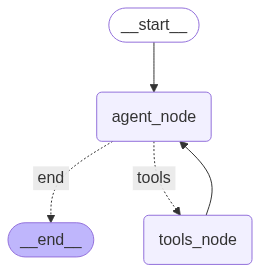

In [2]:
from IPython.display import display, Image

display(Image(
    graph.get_graph().draw_mermaid_png()
))

In [4]:
from agent_graph.state import State
from agent_graph.utils import get_llm_model
from pprint import pprint

test_input: State = {
    "messages": [],
    "handler": "assistant",
    "log": None,
    "model": get_llm_model(),
    "tool_count": 0,
    "query": "can you send a Hello msg to taher_m.16"
}

response = await graph.ainvoke(input=test_input, config={"configurable": {"thread_id": "test_thread"}})

pprint(response)


Entering [agent_node]
HANDLER =>  assistant
MODEL =>  gemini-2.0-flash

At [tools_router] edge
[tools_router] Routing to [tools_node]

Entered [tools_node]
[tool_node] calling -> {'name': 'send_instagram_dm', 'args': {'message': 'Hello', 'username': 'taher_m.16'}, 'id': 'eb745c51-33b5-493b-a577-b8c4c95cc1d2', 'type': 'tool_call'}
Loading existing session...
✓ Session is valid and loaded
Finding user: taher_m.16...


Status 201: JSONDecodeError in public_request (url=https://www.instagram.com/taher_m.16/?__a=1&__d=dis) >>> 
Status 201: JSONDecodeError in public_request (url=https://www.instagram.com/taher_m.16/?__a=1&__d=dis) >>> 
Status 201: JSONDecodeError in public_request (url=https://www.instagram.com/taher_m.16/?__a=1&__d=dis) >>> 


Sending message to @taher_m.16...
✓ Message sent successfully to @taher_m.16

Entering [agent_node]
HANDLER =>  assistant
MODEL =>  gemini-2.0-flash

At [tools_router] edge
[tools_router] Routing to [END]
{'handler': 'assistant',
 'log': None,
 'messages': [HumanMessage(content='can you send a Hello msg to taher_m.16', additional_kwargs={}, response_metadata={}, id='f7d89c07-81c9-4690-8d7e-a133b64dec08'),
              SystemMessage(content="\nYou are ApplePie200, a discord bot who is designed to assist users with their daily tasks.\nYou are smart and clever and your goal is to answer the user's chat (mentioned below) in a frank, funny, and witty fashion.\nMake sure your responses are short and sweet but also answer's the user's prompt in detail. NO BIG PARAGRAPHS NEEDED AT ALL. DO NOT GASLIGHT AND LEAVE YOUR TASK MID PROGRESS. COMPLETE IT EVEN IF YOU HAVE TO WRITE A SLIGHTLY LARGER RESPONSE.\nMake sure to use relevant emojis to make your responses more expressive.\nYou are allowed to 